In [1]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt

from data import pipeline
from data.window import SlidingWindow

# Load the TensorBoard notebook extension
%load_ext tensorboard

import tensorflow as tf
import datetime

# Clear any logs from previous runs

!rm -rf ./logs/

2023-01-12 23:30:35.767321: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Data preparation

In [2]:
# Load / Build dataset

X_train, Y_train, Y_train_prior, X_val, Y_val, X_test, Y_test, Y_test_prior = pipeline.buildAndSave("LSTM") # load / buildAndSave / build
print(X_train.shape, Y_train.shape)

Loading LSTM dataset
Done!
(1050578, 4, 8) (1050578, 1)


In [3]:
# Normalisation

from sklearn.preprocessing import StandardScaler

X_train = X_train.reshape(-1, 32)
X_val = X_val.reshape(-1, 32)
X_test = X_test.reshape(-1, 32)

sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_val = sc_X.fit_transform(X_val)
X_test = sc_X.transform(X_test)

sc_y = StandardScaler()
Y_train = sc_y.fit_transform(Y_train.reshape(-1, 1))

X_train = X_train.reshape(-1, 4, 8)
X_val = X_val.reshape(-1, 4, 8)
X_test = X_test.reshape(-1, 4, 8)

print(X_train.shape, Y_train.shape)

(1050578, 4, 8) (1050578, 1)


# Training

In [4]:
# Import libraries for training and tuning

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import keras_tuner as kt
from keras_tuner import BayesianOptimization, Objective

tune = False
overwrite = False
use_hyperparams = False
fit = False

In [5]:
# Visualise the loss

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

### Tuning

In [6]:
# Define the hypermodel

def buildLSTM(units, learning_rate):
    model = Sequential()
    model.add(LSTM(units= units,
                   activation= 'relu',
                   input_shape= (4, 8)))
    model.add(Dense(1))
    model.compile(optimizer= Adam(learning_rate= learning_rate),
                  loss= 'mean_squared_error',
                  metrics= [RootMeanSquaredError()])
    return model


class HyperLSTMModel(kt.HyperModel):
    def build(self, hp):
        # Tune the number of units in the LSTM per cell in the layer
        # units between 50-90
        hp_units = hp.Int('units', min_value= 50, max_value= 90, step= 5)
        
        # Tune the learning rate for the optimizer
        # learning_rate from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        
        return buildLSTM(hp_units, hp_learning_rate)

    def fit(self, hp, model, *args, **kwargs):
        # Tune the batch size backpropagate the gradient less often
        # batch_size between 37-370
        hp_batch_size = hp.Int('batch_size', min_value= 37, max_value= 37*10, step= 37)
        
        return model.fit(*args, batch_size= hp_batch_size, **kwargs,)


In [7]:
# Define the model with default hyperparameters

if fit and not use_hyperparams:
    model = buildLSTM(units= 70,
                      learning_rate= 0.002)
    batch_size = 37

In [8]:
# Define the tuner

if tune or use_hyperparams:
    tuner = BayesianOptimization(
        hypermodel= HyperLSTMModel(),
        objective= Objective('val_root_mean_squared_error', direction= 'min'),
        num_initial_points= 2,
        executions_per_trial= 3,
        max_trials= 8,
        project_name= 'lstm_automl',
        overwrite= overwrite
    )

In [9]:
# Reload the tuner

if not overwrite and use_hyperparams:
    tuner.reload()


# Search the best hyperparameters

if tune:
    %tensorboard --logdir logs/fit
    
    history = tuner.search(x= X_train, y= Y_train,
                           epochs= 5, 
                           validation_data= (X_val, Y_val), 
                           callbacks= [tensorboard_callback])

    # Get the results of the tuning

    tuner.results_summary()


if tune or use_hyperparams:
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    msg = f"""The best:
    - dimension of the hidden state found is {best_hps.get('units')}
    - learning rate found is {best_hps.get('learning_rate')}
    - batch size found is {best_hps.get('batch_size')}"""
    print(msg)

    with open('lstm_output.txt', 'w') as f:
        f.write(msg)

In [10]:
# Reload the hypermodel from the tuner

if use_hyperparams:
    tuner.reload()
    model = tuner.hypermodel.build(best_hps)

### Fitting

In [11]:
# Reload the model

if not fit:
    model = load_model("lstm_model")


# Train the model

if fit:
    if use_hyperparams and 'batch_size' in best_hps:
        batch_size = best_hps.get('batch_size')
    
    %tensorboard --logdir logs/fit
    
    history = model.fit(X_train, Y_train,
                        batch_size= batch_size,
                        validation_data= (X_val, Y_val),
                        epochs= 10,
                        callbacks= [tensorboard_callback])


# Save the model

if fit and overwrite:
    model.save("lstm_model")

# Evaluation

In [12]:
# Reduce the size of the test dataset

X_test = X_test[:37*27]
Y_test = Y_test[:37*27]
print(X_test.shape, Y_test.shape)

(999, 4, 8) (999, 1)


In [13]:
Y_test = list(Y_test_prior.reshape(-1)) + list(Y_test[:-3].reshape(-1))

In [14]:
# Compute error naive model

from sklearn.metrics import mean_squared_error
from math import sqrt
import statistics

Y_train = np.concatenate((Y_train_prior, Y_train[:-3]))
Y_train = Y_train.reshape(-1, 1)
Y_train = sc_y.inverse_transform(Y_train)

Y_train = Y_train.reshape(-1, 37)
year_growth_avg = [Y_train[:, decade].mean() for decade in range(37)]

Y_naive = []
while len(Y_naive) < len(Y_test):
        Y_naive += year_growth_avg

In [15]:
print('Test RMSE with naive model : %.3f' % statistics.mean([sqrt(mean_squared_error(Y_test[decade-37:decade], Y_naive[decade-37:decade])) for decade in range(37, len(Y_naive), 37)]))

Test RMSE with naive model : 21.248


In [16]:
# Predict and inject its predictions

sw = SlidingWindow(X_test, reset_cycle= 37)

pred = model.predict(sw.values.reshape(-1, 4, 8), verbose=0) # iterator: 0
Y_preds = [pred]

last_progression = 0
print(0, '%')
while sw.next(pred): # iterator: t-1
    x = sw.values.reshape(-1, 4, 8)
    pred = model.predict(x, verbose=0) # iterator: t
    Y_preds.append(pred)
        
    progression = (sw.it+1) / len(sw.X) * 100
    if progression - last_progression > 1 and not int(progression) % 10:
        print(int(progression), '%')
        last_progression = progression

Y_preds = np.array(Y_preds).reshape(-1, 1)

print('Test RMSE : %.3f' % statistics.mean([sqrt(mean_squared_error(Y_test[decade-37:decade], Y_preds[decade-37:decade])) for decade in range(37, len(Y_preds), 37)]))

0 %
10 %
20 %
30 %
40 %
50 %
60 %
70 %
80 %
90 %
100 %
Test RMSE : 39.850


In [17]:
# Process results for plots

Y_preds = sc_y.inverse_transform(Y_preds)
Y_preds = list(Y_preds.reshape(-1))
Y_preds = [9.57]*3 + Y_preds

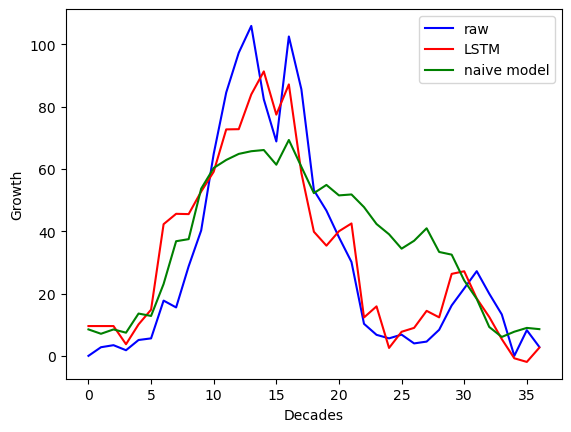

In [19]:
# Plot the results

year = 0
decades = [decade for decade in range(37)]
plt.plot(decades, Y_test[37*year:37*(year+1)], color="blue", label= "raw")
plt.plot(decades, Y_preds[37*year:37*(year+1)], color="red", label= "LSTM")
plt.plot(decades, Y_naive[37*year:37*(year+1)], color="green", label= "naive model")
plt.xlabel("Decades")
plt.ylabel("Growth")
plt.legend()
plt.show()